# Google colab commands

In [1]:
!git clone https://github.com/Francesco9932/financial-sentiment-analysis

Cloning into 'financial-sentiment-analysis'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 122 (delta 34), reused 46 (delta 10), pack-reused 42
Receiving objects: 100% (122/122), 112.85 MiB | 37.79 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
%cd financial-sentiment-analysis/

/content/financial-sentiment-analysis


In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-07-14 13:20:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-07-14 13:20:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-14 13:20:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [4]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.3 MB/s eta 0:00:00


# Import

In [6]:
from transformers import TFDistilBertModel
from transformers import DistilBertTokenizer
import pandas as pd
import numpy as np

# pre-processing
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import *
from nltk.corpus import stopwords
import re
import nltk
nltk.download("stopwords")

from transformers import BertTokenizer
from transformers import TFBertModel
import tensorflow as tf
from keras.utils import pad_sequences
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data preprocessing

In [7]:
df = pd.read_csv('all-data2.csv', encoding="latin-1",
                 names=['headline', 'sentiment'])
df.head()

,headline,sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [8]:
print("original shape: ", df.shape)
df = df.drop_duplicates()
print("after drop duplicates shape: ", df.shape)
dd_dn = df.dropna()
print("after drop null shape: ", df.shape)

original shape:  (5842, 2)
after drop duplicates shape:  (5836, 2)
after drop null shape:  (5836, 2)


In [9]:
df.isnull().sum()

headline     0
sentiment    0
dtype: int64

neutral     53.5
positive    31.7
negative    14.7
Name: sentiment, dtype: float64


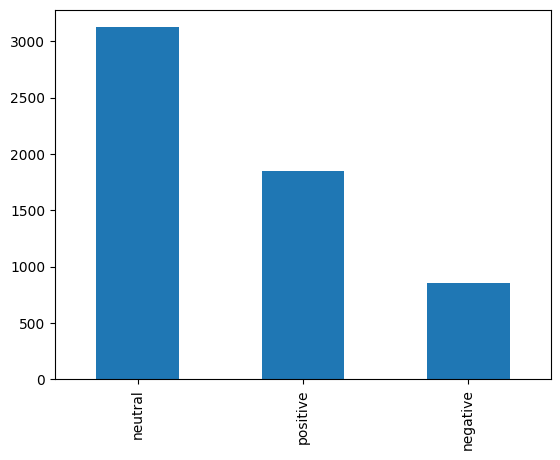

In [10]:
df['sentiment'].value_counts().plot(kind='bar')
class_percentage = df['sentiment'].value_counts() / len(df) * 100
print(round(class_percentage, 1))

In [11]:
import string
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # words = text.split()
    # words = [w for w in words if w not in stopwords.words("english")]
    return text

df['headline'] = df['headline'].apply(preprocess)
#df.to_csv('preprocessed.csv', index=False)

In [ ]:
# Positive tweet
print("Positive news headline example :",df[df['sentiment']=='positive']['headline'].values[1])
#negative_text
print("Negative news headline example :",
      df[df['sentiment'] == 'negative']['headline'].values[1])
#neutral_text
print("Neutral news headline example  :",df[df['sentiment']=='neutral']['headline'].values[1])

In [12]:
sentences = df['headline'].to_list()

# Encode target labels
le = LabelEncoder()
le.fit(df['sentiment'])
df['sentiment'] = le.transform(df['sentiment'])
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [50]:
from matplotlib import pyplot as plt

def plot_train_val_acc(history, title, acc_metric):
    plt.plot(history.history[acc_metric])
    plt.plot(history.history["val_"+acc_metric])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # Ottenere il valore massimo di val_accuracy e l'epoca corrispondente
    max_val_acc = max(history.history['val_accuracy'])
    epoch_with_max_val_acc = history.history['val_accuracy'].index(max_val_acc)

    # Aggiungere un'etichetta per il valore massimo di val_accuracy nel grafico
    plt.annotate(f'Max Val Acc: {max_val_acc:.4f}',
                 xy=(epoch_with_max_val_acc, max_val_acc),
                 xytext=(epoch_with_max_val_acc + 2, max_val_acc + 0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Impostare gli intervalli dell'asse x come interi
    plt.xticks(range(len(history.history[acc_metric])))

    plt.show()



# Tokenizer for other models

In [14]:
tokenizer = keras.preprocessing.text.Tokenizer(lower=True)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index
print("Vocab length:", len(word_index) + 1)

max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
print("Maximum sequence length:", max_seq_length)
sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

Vocab length: 11401
Maximum sequence length: 71


In [15]:
train_sequences, test_sequences, y_train, y_test = train_test_split(sequences, df['sentiment'], train_size=0.7, shuffle=True, random_state=42)

In [16]:
print('Train Set ->', train_sequences.shape, y_train.shape)
print('Test Set ->', test_sequences.shape, y_test.shape)

Train Set -> (4085, 71) (4085,)
Test Set -> (1751, 71) (1751,)


# Global Vectors for Word Representation (GloVe)

In [19]:
vocab_size = 11401
embedding_size = 200

embeddings_index = {}

with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


embeddings_matrix = np.zeros((vocab_size+1, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [20]:
print(embeddings_matrix.shape)

(11402, 200)


# CNN1d Model

In [21]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size+1,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1],
                              weights=[embeddings_matrix])(inputs)

convs = []
filter_sizes = [2,3,4,5,6]

for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=200,
                        kernel_size=filter_size,
                        activation='relu')(x)
    l_pool = tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)

l_merge = tf.keras.layers.concatenate(convs, axis=1)
x = tf.keras.layers.Dropout(0.1)(l_merge)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 71, 200)      2280400     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 70, 200)      80200       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 69, 200)      120200      ['embedding[0][0]']              
                                                                                              

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_cnn1d.h5',
                     monitor='val_accuracy', mode='max', verbose=1,
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.5982
Epoch 1: val_accuracy improved from -inf to 0.59902, saving model to ./best_model/best_model_cnn1d.h5
115/115 [==============================] - 39s 193ms/step - loss: 0.9467 - accuracy: 0.5982 - val_loss: 0.8547 - val_accuracy: 0.5990
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.6174 - accuracy: 0.7353
Epoch 2: val_accuracy improved from 0.59902 to 0.66504, saving model to ./best_model/best_model_cnn1d.h5
115/115 [==============================] - 10s 90ms/step - loss: 0.6174 - accuracy: 0.7353 - val_loss: 0.7116 - val_accuracy: 0.6650
Epoch 3/100
111/115 [===========================>..] - ETA: 0s - loss: 0.3757 - accuracy: 0.8401
Epoch 3: val_accuracy improved from 0.66504 to 0.66993, saving model to ./best_model/best_model_cnn1d.h5
115/115 [==============================] - 3s 29ms/step - loss: 0.3758 - accuracy: 0.8390 - val_loss: 0.7311 - val_accuracy: 0.669

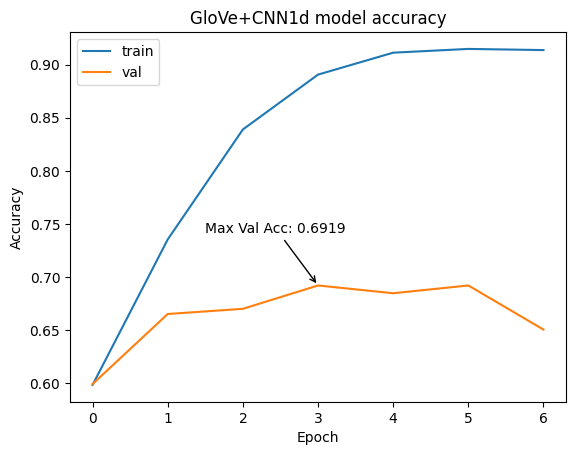

In [23]:
plot_train_val_acc(history, "GloVe+CNN1d model accuracy", "accuracy")

In [24]:
saved_model = load_model('./best_model/best_model_cnn1d.h5')
# Classification report:
predicted = saved_model.predict(test_sequences)
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(y_test, y_predicted, digits=4))

55/55 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0     0.3971    0.2118    0.2762       255
           1     0.7652    0.8545    0.8074       969
           2     0.7505    0.7590    0.7547       527

    accuracy                         0.7322      1751
   macro avg     0.6376    0.6084    0.6128      1751
weighted avg     0.7072    0.7322    0.7142      1751



In [ ]:
# Example of prediction
def tokenize_sentence(sentence, tokenizer=tokenizer):
    tokenized_sentence = tokenizer.texts_to_sequences(sentence)
    padded_sentence = pad_sequences(
        tokenized_sentence, maxlen=max_seq_length, padding='post')
    return padded_sentence


tokenized_positive_sentence = tokenize_sentence(
    df[df['sentiment'] == 2]['headline'].values[0])  # 2 positive
tokenized_negative_sentence = tokenize_sentence(
    df[df['sentiment'] == 0]['headline'].values[0])  # 0 negative
tokenized_neutral_sentence = tokenize_sentence(
    df[df['sentiment'] == 1]['headline'].values[0])  # 1 neutral

predicted1 = saved_model.predict(tokenized_positive_sentence)
y_predicted1 = np.argmax(predicted1, axis=1)

print("Positive sentence prediction: ", y_predicted1[0])
print("Positive sentence true label: ",
      df[df['sentiment'] == 2]['sentiment'].values[0])
print("-"*50)

predicted2 = saved_model.predict(tokenized_negative_sentence)
y_predicted2 = np.argmax(predicted2, axis=1)

print("Negative sentence prediction: ", y_predicted2[0])
print("Negative sentence true label: ",
      df[df['sentiment'] == 0]['sentiment'].values[0])
print("-"*50)

predicted3 = saved_model.predict(tokenized_neutral_sentence)
y_predicted3 = np.argmax(predicted3, axis=1)

print("Neutral sentence prediction: ", y_predicted3[0])
print("Neutral sentence true label: ",
      df[df['sentiment'] == 1]['sentiment'].values[0])
print("-"*50)


7/7 [==============================] - 0s 15ms/step
Positive sentence prediction:  1
Positive sentence true label:  2
--------------------------------------------------
8/8 [==============================] - 0s 14ms/step
Negative sentence prediction:  1
Negative sentence true label:  0
--------------------------------------------------
4/4 [==============================] - 0s 18ms/step
Neutral sentence prediction:  1
Neutral sentence true label:  1
--------------------------------------------------


# LSTM Model

In [25]:
inputs = tf.keras.Input(shape=(train_sequences.shape[1],))
x = tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_size,
                              input_length=train_sequences.shape[1])(inputs)
x = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 71)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 71, 200)           2280200   
                                                                 
 lstm (LSTM)                 (None, 71, 256)           467968    
                                                                 
 flatten (Flatten)           (None, 18176)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 54531     
                                                                 
Total params: 2,802,699
Trainable params: 2,802,699
Non-trainable params: 0
_________________________________________________________________


In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model/best_model_lstm.h5',
                     monitor='val_accuracy', mode='max', verbose=1,
                     save_best_only=True)

history = model.fit(train_sequences,
                    y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.8791 - accuracy: 0.6023
Epoch 1: val_accuracy improved from -inf to 0.67971, saving model to ./best_model/best_model_lstm.h5
115/115 [==============================] - 23s 169ms/step - loss: 0.8791 - accuracy: 0.6023 - val_loss: 0.7671 - val_accuracy: 0.6797
Epoch 2/100
113/115 [============================>.] - ETA: 0s - loss: 0.4602 - accuracy: 0.8075
Epoch 2: val_accuracy did not improve from 0.67971
115/115 [==============================] - 8s 72ms/step - loss: 0.4591 - accuracy: 0.8082 - val_loss: 0.8275 - val_accuracy: 0.6724
Epoch 3/100
111/115 [===========================>..] - ETA: 0s - loss: 0.2342 - accuracy: 0.8975
Epoch 3: val_accuracy did not improve from 0.67971
115/115 [==============================] - 5s 45ms/step - loss: 0.2375 - accuracy: 0.8950 - val_loss: 0.8729 - val_accuracy: 0.6675
Epoch 4/100
115/115 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9100
Epoch 4: va

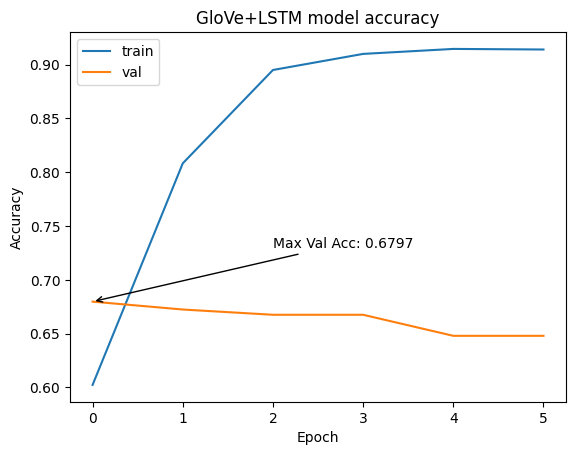

In [30]:
plot_train_val_acc(history, "GloVe+LSTM model accuracy", "accuracy")

In [31]:
saved_model = load_model('./best_model/best_model_lstm.h5')
# Classification report:
predicted = saved_model.predict(test_sequences)
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(y_test, y_predicted, digits=4))


55/55 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0     0.4538    0.2118    0.2888       255
           1     0.7562    0.8132    0.7837       969
           2     0.6254    0.7002    0.6607       527

    accuracy                         0.6916      1751
   macro avg     0.6118    0.5751    0.5777      1751
weighted avg     0.6728    0.6916    0.6746      1751



In [ ]:
# Example of prediction
def tokenize_sentence(sentence, tokenizer=tokenizer):
    tokenized_sentence = tokenizer.texts_to_sequences(sentence)
    padded_sentence = pad_sequences(
        tokenized_sentence, maxlen=max_seq_length, padding='post')
    return padded_sentence


tokenized_positive_sentence = tokenize_sentence(
    df[df['sentiment'] == 2]['headline'].values[0])  # 2 positive
tokenized_negative_sentence = tokenize_sentence(
    df[df['sentiment'] == 0]['headline'].values[0])  # 0 negative
tokenized_neutral_sentence = tokenize_sentence(
    df[df['sentiment'] == 1]['headline'].values[0])  # 1 neutral

predicted1 = saved_model.predict(tokenized_positive_sentence)
y_predicted1 = np.argmax(predicted1, axis=1)

print("Positive sentence prediction: ", y_predicted1[0])
print("Positive sentence true label: ",
      df[df['sentiment'] == 2]['sentiment'].values[0])
print("-"*50)

predicted2 = saved_model.predict(tokenized_negative_sentence)
y_predicted2 = np.argmax(predicted2, axis=1)

print("Negative sentence prediction: ", y_predicted2[0])
print("Negative sentence true label: ",
      df[df['sentiment'] == 0]['sentiment'].values[0])
print("-"*50)

predicted3 = saved_model.predict(tokenized_neutral_sentence)
y_predicted3 = np.argmax(predicted3, axis=1)

print("Neutral sentence prediction: ", y_predicted3[0])
print("Neutral sentence true label: ",
      df[df['sentiment'] == 1]['sentiment'].values[0])
print("-"*50)


7/7 [==============================] - 0s 43ms/step
Positive sentence prediction:  1
Positive sentence true label:  2
--------------------------------------------------
8/8 [==============================] - 0s 49ms/step
Negative sentence prediction:  1
Negative sentence true label:  0
--------------------------------------------------
4/4 [==============================] - 0s 52ms/step
Neutral sentence prediction:  1
Neutral sentence true label:  1
--------------------------------------------------


# BERT Finetune

In [32]:
finBertTokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
finBert = TFBertModel.from_pretrained('ProsusAI/finbert')

distilBertTokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilBert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [33]:
def create_BERT_wrapper(bert_embeddings, max_len):
    input_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="attention_mask")

    embeddings = bert_embeddings(input_ids, attention_mask=input_mask)[
        0]  # 0 = last hidden state, 1 = poller_output

    out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    out = tf.keras.layers.Dense(128, activation='relu')(out)
    out = tf.keras.layers.Dropout(0.1)(out)
    out = tf.keras.layers.Dense(32, activation='relu')(out)

    y = tf.keras.layers.Dense(3, activation='softmax')(out)

    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

    model.layers[2].trainable = True
    # check https://stackoverflow.com/questions/60463829/training-tfbertforsequenceclassification-with-custom-x-and-y-data

    return model


In [34]:
def calculate_max_sentence_len(sentences, tokenizer):
    max_len = 0

    # For every sentence...
    for sent in sentences:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    return max_len

In [ ]:
"""def train_test_set(tokenizer):
    train_sentences, test_sentences, labels_train, labels_test = train_test_split(
        sentences, df['sentiment'], train_size=0.7, shuffle=True, random_state=42)

    max_len = min(calculate_max_sentence_len(train_sentences, tokenizer),
                  calculate_max_sentence_len(test_sentences, tokenizer))

    print('Max sentence length: ', max_len)

    X_train = tokenizer(
        text=train_sentences,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)

    X_test = tokenizer(
        text=test_sentences,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )
    # the same for attention mask
    print("\nTrain split shape: ", X_train['input_ids'].shape)
    print("\nTest split shape: ", X_test['input_ids'].shape)
    print(X_train['input_ids'])
    print(X_train['attention_mask'])

    return X_train, X_test, labels_train, labels_test, max_len """


In [ ]:
"""X_train, X_test, labels_train, labels_test, max_len_finBert = train_test_set(
    finBertTokenizer)"""


In [35]:
def train_test_set(tokenizer):
    max_len = calculate_max_sentence_len(sentences, tokenizer)
    print('Max sentence length: ', max_len)

    train_sentences, test_sentences, labels_train, labels_test = train_test_split(
    sentences, df['sentiment'], train_size=0.7, shuffle=True, random_state=42)

    X_train = {"input_ids" : [], "attention_mask" : []}
    X_test = {"input_ids" : [], "attention_mask" : []}

    for sentence in train_sentences:

            # `encode_plus` will:
            #    (1) Tokenize the sentence
            #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
            #    (3) Truncate/Pad sentence to max length
            #    (4) Map tokens to their IDs
            #    (5) Create attention mask
            #    (6) Return a dictionary of outputs

        encoded_sent = tokenizer.encode_plus(
            text=sentence,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            padding='max_length',
            truncation=True,       # Pad sentence to max length
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='tf',
            verbose=True     # Return attention mask
        )

        # Add the outputs to the lists
        X_train["input_ids"].append(encoded_sent.get('input_ids'))
        X_train["attention_mask"].append(encoded_sent.get('attention_mask'))

    for sentence in test_sentences:
        encoded_sent = tokenizer.encode_plus(
            text=sentence,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            padding='max_length',
            truncation=True,       # Pad sentence to max length
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='tf',
            verbose=True     # Return attention mask
        )

        X_test["input_ids"].append(encoded_sent.get('input_ids'))
        X_test["attention_mask"].append(encoded_sent.get('attention_mask'))

    for key in ["input_ids", "attention_mask"]:
        X_train[key] = np.array(X_train[key])
        X_test[key] = np.array(X_test[key])
        X_train[key] = X_train[key].reshape(X_train[key].shape[0], max_len)
        X_test[key] = X_test[key].reshape(X_test[key].shape[0], max_len)

    # the same for attention mask
    print("\nTrain split shape: ", X_train['input_ids'].shape)
    print("\nTest split shape: ", X_test['input_ids'].shape)

    return X_train, X_test, labels_train, labels_test, max_len

In [36]:
X_train, X_test, labels_train, labels_test, max_len_finBert = train_test_set(finBertTokenizer)

Max sentence length:  111

Train split shape:  (4085, 111)

Test split shape:  (1751, 111)


# finBERT

In [37]:
model = create_BERT_wrapper(finBert, max_len_finBert)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-05,  # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 111)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 111)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 111,                                         

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('./best_model/finetuned_finbert.h5',
                     monitor='val_accuracy', mode='max', verbose=1,
                     save_best_only=True)

history = model.fit(x= {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
                    y= tf.keras.utils.to_categorical(labels_train),
                    batch_size=32,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


115/115 [==============================] - ETA: 0s - loss: 0.5376 - accuracy: 0.7527
Epoch 1: val_accuracy improved from -inf to 0.77262, saving model to ./best_model/finetuned_finbert.h5
115/115 [==============================] - 172s 963ms/step - loss: 0.5376 - accuracy: 0.7527 - val_loss: 0.4521 - val_accuracy: 0.7726
Epoch 2/10
115/115 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8528
Epoch 2: val_accuracy did not improve from 0.77262
115/115 [==============================] - 94s 817ms/step - loss: 0.3083 - accuracy: 0.8528 - val_loss: 0.5174 - val_accuracy: 0.7506
Epoch 3/10
115/115 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.8743
Epoch 3: val_accuracy improved from 0.77262 to 0.77995, saving model to ./best_model/finetuned_finbert.h5
115/115 [==============================] - 108s 939ms/step - loss: 0.2352 - accuracy: 0.8743 - val_loss: 0.5298 - val_accuracy: 0.7800
Epoch 4/10
115/115 [==============================] - ETA: 

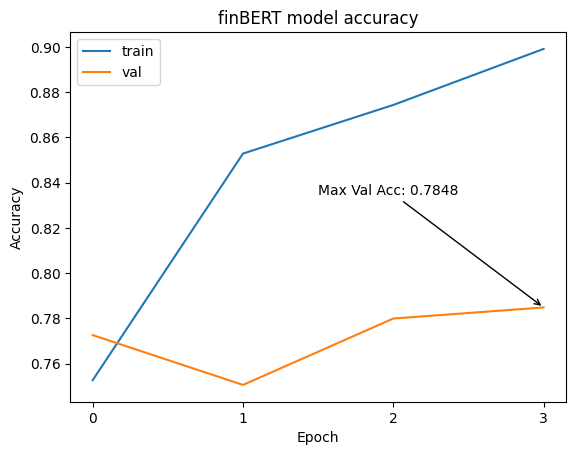

In [43]:
plot_train_val_acc(history, "finBERT model accuracy", "accuracy")

In [40]:
saved_model = load_model('./best_model/finetuned_finbert.h5',
                         custom_objects={"TFBertModel": TFBertModel})


In [41]:
# Classification report:
predicted = saved_model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(labels_test, y_predicted, digits=4))

55/55 [==============================] - 17s 249ms/step
              precision    recall  f1-score   support

           0     0.4868    0.5804    0.5295       255
           1     0.8628    0.7915    0.8256       969
           2     0.8136    0.8615    0.8369       527

    accuracy                         0.7818      1751
   macro avg     0.7211    0.7445    0.7307      1751
weighted avg     0.7932    0.7818    0.7859      1751



In [ ]:
# Example of prediction
def tokenize_sentence(sentence, tokenizer):
    tokenized_sentence = tokenizer.encode_plus(
        text=sentence,  # Preprocess sentence
        add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
        max_length=max_len_finBert,                  # Max length to truncate/pad
        pad_to_max_length=True,         # Pad sentence to max length
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='tf',
        verbose=True     # Return attention mask
    )
    return tokenized_sentence

tokenized_positive_sentence = tokenize_sentence(
    df[df['sentiment'] == 'positive']['headline'].values[0], finBertTokenizer)
tokenized_negative_sentence = tokenize_sentence(
    df[df['sentiment'] == 'negative']['headline'].values[0], finBertTokenizer)
tokenized_neutral_sentence = tokenize_sentence(
    df[df['sentiment'] == 'neutral']['headline'].values[0], finBertTokenizer)

predicted1 = saved_model.predict(
    {'input_ids': tokenized_positive_sentence['input_ids'], 'attention_mask': tokenized_positive_sentence['attention_mask']})
y_predicted1 = np.argmax(predicted1, axis=1)

print("Positive sentence prediction: ", le.inverse_transform(y_predicted1)[0])
print("Positive sentence true label: ",
      df[df['sentiment'] == 'positive']['sentiment'].values[0])
print("-"*50)

predicted2 = saved_model.predict(
    {'input_ids': tokenized_negative_sentence['input_ids'], 'attention_mask': tokenized_negative_sentence['attention_mask']})
y_predicted2 = np.argmax(predicted2, axis=1)

print("Negative sentence prediction: ", le.inverse_transform(y_predicted2)[0])
print("Negative sentence true label: ",
      df[df['sentiment'] == 'negative']['sentiment'].values[0])
print("-"*50)

predicted3 = saved_model.predict(
    {'input_ids': tokenized_neutral_sentence['input_ids'], 'attention_mask': tokenized_neutral_sentence['attention_mask']})
y_predicted3 = np.argmax(predicted3, axis=1)

print("Neutral sentence prediction: ", le.inverse_transform(y_predicted3)[0])
print("Neutral sentence true label: ",
      df[df['sentiment'] == 'neutral']['sentiment'].values[0])
print("-"*50)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 165ms/step
Positive sentence prediction:  positive
Positive sentence true label:  positive
--------------------------------------------------
1/1 [==============================] - 0s 134ms/step
Negative sentence prediction:  negative
Negative sentence true label:  negative
--------------------------------------------------
1/1 [==============================] - 0s 133ms/step
Neutral sentence prediction:  neutral
Neutral sentence true label:  neutral
--------------------------------------------------


# distilBERT

In [44]:
X_train, X_test, labels_train, labels_test, max_len_distilBert = train_test_set(distilBertTokenizer)

Max sentence length:  111

Train split shape:  (4085, 111)

Test split shape:  (1751, 111)


In [45]:
model = create_BERT_wrapper(distilBert, max_len_distilBert)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-05,  # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 111)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 111)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 111, 768),                                                   
                                 hidden_states=None                                         

In [46]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('./best_model/finetuned_distilbert.h5',
                     monitor='val_accuracy', mode='max', verbose=1,
                     save_best_only=True)

history = model.fit(x= {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
                    y= tf.keras.utils.to_categorical(labels_train),
                    batch_size=32,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[es, mc])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


115/115 [==============================] - ETA: 0s - loss: 0.7008 - accuracy: 0.6651
Epoch 1: val_accuracy improved from -inf to 0.73105, saving model to ./best_model/finetuned_distilbert.h5
115/115 [==============================] - 88s 525ms/step - loss: 0.7008 - accuracy: 0.6651 - val_loss: 0.5355 - val_accuracy: 0.7311
Epoch 2/10
115/115 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8264
Epoch 2: val_accuracy did not improve from 0.73105
115/115 [==============================] - 46s 402ms/step - loss: 0.3833 - accuracy: 0.8264 - val_loss: 0.5754 - val_accuracy: 0.7213
Epoch 3/10
115/115 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.8705
Epoch 3: val_accuracy did not improve from 0.73105
115/115 [==============================] - 47s 408ms/step - loss: 0.2605 - accuracy: 0.8705 - val_loss: 0.6495 - val_accuracy: 0.7262
Epoch 4/10
115/115 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.8942
Epoch 4: val_accu

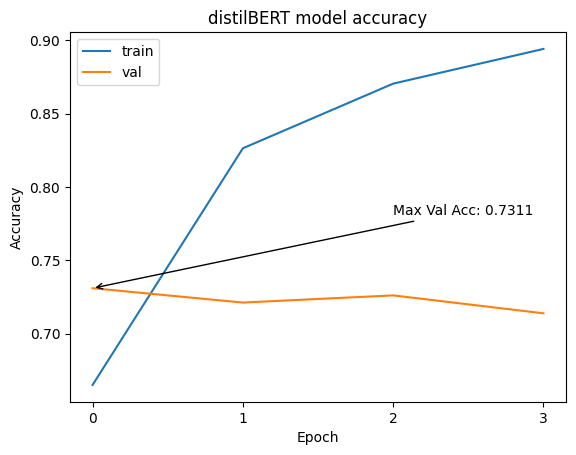

In [51]:
plot_train_val_acc(history, "distilBERT model accuracy", "accuracy")

In [48]:
saved_model = load_model('./best_model/finetuned_distilbert.h5',
                         custom_objects={"TFDistilBertModel": TFDistilBertModel})


In [49]:
# Classification report:
predicted = saved_model.predict(
    {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(labels_test, y_predicted, digits=4))

55/55 [==============================] - 8s 124ms/step
              precision    recall  f1-score   support

           0     0.5000    0.4235    0.4586       255
           1     0.8217    0.8369    0.8292       969
           2     0.7664    0.7970    0.7814       527

    accuracy                         0.7647      1751
   macro avg     0.6960    0.6858    0.6897      1751
weighted avg     0.7582    0.7647    0.7609      1751



In [ ]:
# Example of prediction
def tokenize_sentence(sentence, tokenizer=distilBertTokenizer):
    tokenized_sentence = tokenizer.encode_plus(
        text=sentence,  # Preprocess sentence
        add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
        max_length=120,                  # Max length to truncate/pad
        pad_to_max_length=True,         # Pad sentence to max length
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='tf',
        verbose=True     # Return attention mask
    )
    return tokenized_sentence

tokenized_positive_sentence = tokenize_sentence(df[df['sentiment']=='positive']['headline'].values[0])
tokenized_negative_sentence = tokenize_sentence(df[df['sentiment'] == 'negative']['headline'].values[0])
tokenized_neutral_sentence = tokenize_sentence(df[df['sentiment']=='neutral']['headline'].values[0])

predicted1 = saved_model.predict(
    {'input_ids': tokenized_positive_sentence['input_ids'], 'attention_mask': tokenized_positive_sentence['attention_mask']})
y_predicted1 = np.argmax(predicted1, axis=1)

print("Positive sentence prediction: ", le.inverse_transform(y_predicted1)[0])
print("Positive sentence true label: ", df[df['sentiment']=='positive']['sentiment'].values[0])
print("-"*50)

predicted2 = saved_model.predict(
    {'input_ids': tokenized_negative_sentence['input_ids'], 'attention_mask': tokenized_negative_sentence['attention_mask']})
y_predicted2 = np.argmax(predicted2, axis=1)

print("Negative sentence prediction: ", le.inverse_transform(y_predicted2)[0])
print("Negative sentence true label: ", df[df['sentiment']=='negative']['sentiment'].values[0])
print("-"*50)

predicted3 = saved_model.predict({'input_ids': tokenized_neutral_sentence['input_ids'], 'attention_mask': tokenized_neutral_sentence['attention_mask']})
y_predicted3 = np.argmax(predicted3, axis=1)

print("Neutral sentence prediction: ", le.inverse_transform(y_predicted3)[0])
print("Neutral sentence true label: ", df[df['sentiment']=='neutral']['sentiment'].values[0])
print("-"*50)
